<a href="https://www.kaggle.com/code/aleksandrmorozov123/rt-detr-inference?scriptVersionId=226616194" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/road-lane-instance-segmentation/road_lane_instance_segmentation/README.dataset.txt
/kaggle/input/road-lane-instance-segmentation/road_lane_instance_segmentation/README.roboflow.txt
/kaggle/input/road-lane-instance-segmentation/road_lane_instance_segmentation/val2017/Dash_Cam_Owners_Indonesia_414_December_2022_mp4_9180_jpg.rf.1b2840a7af1096da1404bdf7580c76b2.jpg
/kaggle/input/road-lane-instance-segmentation/road_lane_instance_segmentation/val2017/MOVA5100_avi_540_jpg.rf.1c24a770334a43a5e8d0a720336efd83.jpg
/kaggle/input/road-lane-instance-segmentation/road_lane_instance_segmentation/val2017/2023-06-15_14-25-57-front_mp4_1740_jpg.rf.ce995d1125e8d34ed77e3b7ed56b79ec.jpg
/kaggle/input/road-lane-instance-segmentation/road_lane_instance_segmentation/val2017/Dash_Cam_Owners_Indonesia_414_December_2022_mp4_10380_jpg.rf.8a822e4971fa3c211f4aecf2a4f54c40.jpg
/kaggle/input/road-lane-instance-segmentation/road_lane_instance_segmentation/val2017/Dash_Cam_Owners_Indonesia_495_June_2023_

**RT-DETR**, short for "Real-Time DEtection TRansformer", is a computer vision model developed by the Peking University and Baidu.

In [2]:
# install dependencies

!pip install -q git+https://github.com/huggingface/transformers.git
!pip install -q git+https://github.com/roboflow/supervision.git
!pip install -q roboflow
!pip install -q accelerate 
!pip install -q torchmetrics
!pip install -q "albumentations>=1.4.5"

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.1/83.1 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 4.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.10.0 requires tensorflow==2.17.0, but you have tensorflow 2.17.1 which is incompatible.


In [3]:
# import required libraries

import torch
import requests

import numpy as np
import supervision as sv
import albumentations as A

from PIL import Image
from pprint import pprint
from roboflow import Roboflow
from dataclasses import dataclass, replace
from torch.utils.data import Dataset
from transformers import AutoImageProcessor, AutoModelForObjectDetection, TrainingArguments, Trainer
from torchmetrics.detection.mean_ap import MeanAveragePrecision

**Infrence with the pre-trained RT-DETR model**

In [4]:
CHECKPOINT = "PekingU/rtdetr_r50vd_coco_o365"
DEVICE = torch.device ("cuda" if torch.cuda.is_available () else "cpu")

model = AutoModelForObjectDetection.from_pretrained (CHECKPOINT).to (DEVICE)
processor = AutoImageProcessor.from_pretrained (CHECKPOINT)

config.json:   0%|          | 0.00/5.11k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/172M [00:00<?, ?B/s]

TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].


preprocessor_config.json:   0%|          | 0.00/841 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [5]:
img = "/kaggle/input/road-lane-instance-segmentation/road_lane_instance_segmentation/train2017/2023-06-15_14-06-50-front_mp4_0_jpg.rf.0792eb3c2145b288b835bca1818dc742.jpg"

image = Image.open (img)
inputs = processor (image, return_tensors = "pt").to (DEVICE)

with torch.no_grad ():
    outputs = model (**inputs)

w, h = image.size
results = processor.post_process_object_detection (
    outputs, target_sizes = [(h, w)], threshold = 0.3)

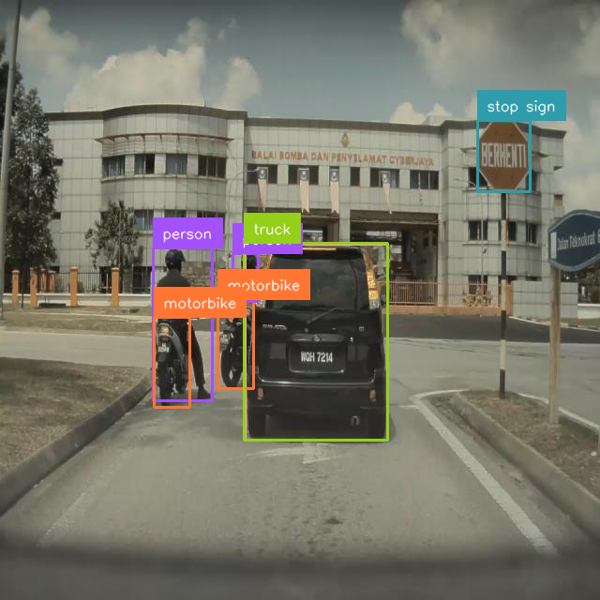

In [6]:
detections = sv.Detections.from_transformers (results [0])
labels = [
    model.config.id2label [class_id]
    for class_id 
    in detections.class_id
]

annotated_image = image.copy ()
annotated_image = sv.BoxAnnotator().annotate(annotated_image, detections)
annotated_image = sv.LabelAnnotator ().annotate (annotated_image, detections, labels = labels)
annotated_image.thumbnail ((600, 600))
annotated_image

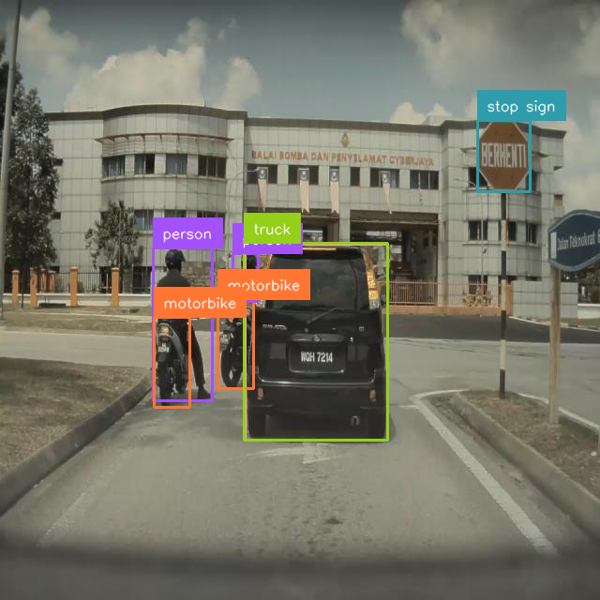

In [7]:
# inference with NMS (non maximum suppression)
detections = sv.Detections.from_transformers(results[0])
labels = [
    model.config.id2label[class_id]
    for class_id
    in detections.class_id
]

annotated_image = image.copy()
annotated_image = sv.BoxAnnotator().annotate(annotated_image, detections)
annotated_image = sv.LabelAnnotator().annotate(annotated_image, detections, labels=labels)
annotated_image.thumbnail((600, 600))
annotated_image

**Fine-tune RT-DETR on kaggle dataset**

In [8]:
ds_train = sv.DetectionDataset.from_coco(
    images_directory_path=f"/kaggle/input/road-lane-instance-segmentation/road_lane_instance_segmentation/train2017",
    annotations_path=f"/kaggle/input/road-lane-instance-segmentation/road_lane_instance_segmentation/annotations/instances_train2017.json",
)
ds_valid = sv.DetectionDataset.from_coco(
    images_directory_path=f"/kaggle/input/road-lane-instance-segmentation/road_lane_instance_segmentation/val2017",
    annotations_path=f"/kaggle/input/road-lane-instance-segmentation/road_lane_instance_segmentation/annotations/instances_val2017.json",
)


print(f"Number of training images: {len(ds_train)}")
print(f"Number of validation images: {len(ds_valid)}")

Number of training images: 1021
Number of validation images: 112


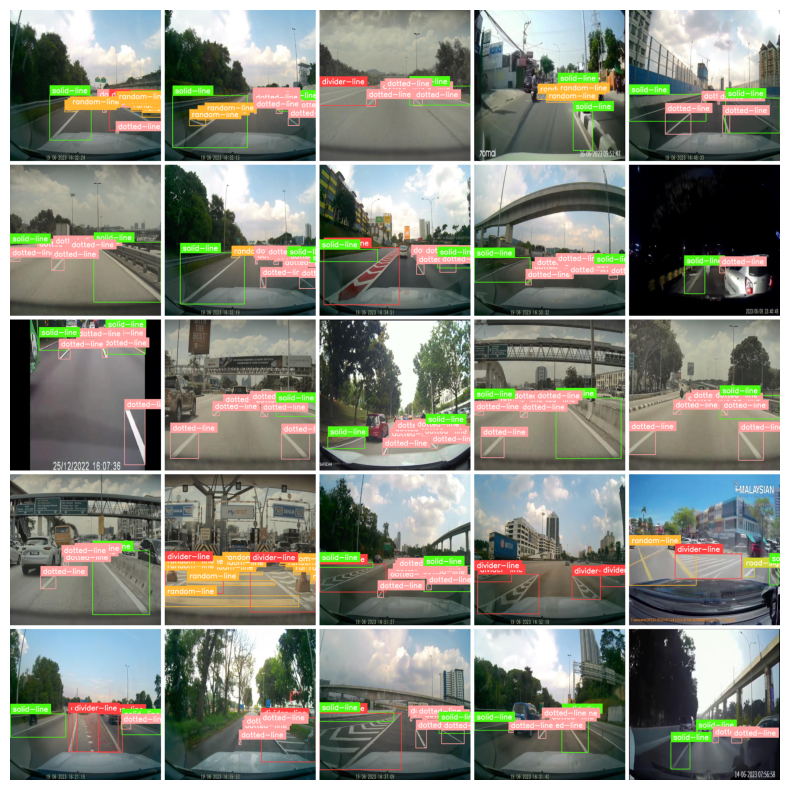

In [9]:
# display sample from dataset

GRID_SIZE = 5

def annotate(image, annotations, classes):
    labels = [
        classes[class_id]
        for class_id
        in annotations.class_id
    ]

    bounding_box_annotator = sv.BoxAnnotator()
    label_annotator = sv.LabelAnnotator(text_scale=1, text_thickness=2)

    annotated_image = image.copy()
    annotated_image = bounding_box_annotator.annotate(annotated_image, annotations)
    annotated_image = label_annotator.annotate(annotated_image, annotations, labels=labels)
    return annotated_image

annotated_images = []
for i in range(GRID_SIZE * GRID_SIZE):
    _, image, annotations = ds_train[i]
    annotated_image = annotate(image, annotations, ds_train.classes)
    annotated_images.append(annotated_image)

grid = sv.create_tiles(
    annotated_images,
    grid_size=(GRID_SIZE, GRID_SIZE),
    single_tile_size=(400, 400),
    tile_padding_color=sv.Color.WHITE,
    tile_margin_color=sv.Color.WHITE
)
sv.plot_image(grid, size=(10, 10))

**Preprocess the images on dataset**

In [10]:
IMAGE_SIZE = 480

processor = AutoImageProcessor.from_pretrained(
    CHECKPOINT,
    do_resize=True,
    size={"width": IMAGE_SIZE, "height": IMAGE_SIZE},
)

In [11]:
# apply image augmentation
train_augmentation_and_transform = A.Compose(
    [
        A.Perspective(p=0.1),
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.HueSaturationValue(p=0.1),
    ],
    bbox_params=A.BboxParams(
        format="pascal_voc",
        label_fields=["category"],
        clip=True,
        min_area=25
    ),
)

valid_transform = A.Compose(
    [A.NoOp()],
    bbox_params=A.BboxParams(
        format="pascal_voc",
        label_fields=["category"],
        clip=True,
        min_area=1
    ),
)

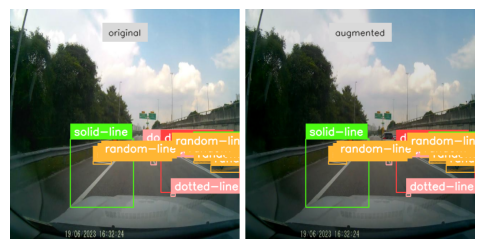

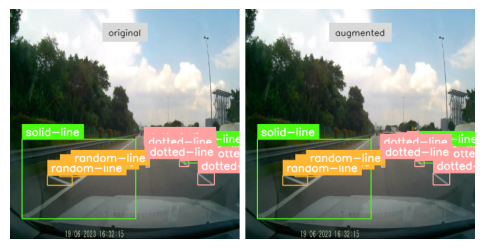

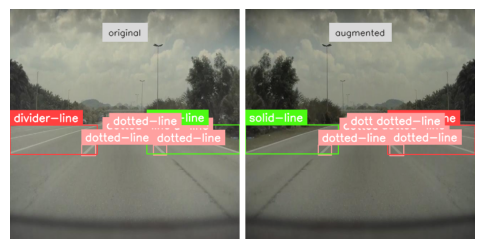

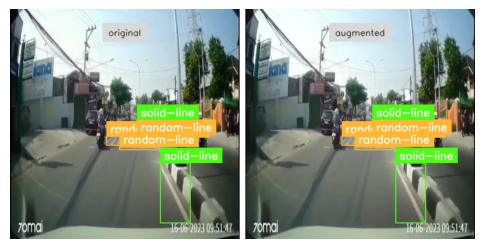

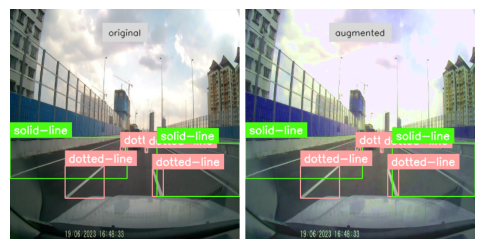

In [12]:
# create grid from some augmented images

IMAGE_COUNT = 5

for i in range(IMAGE_COUNT):
    _, image, annotations = ds_train[i]

    output = train_augmentation_and_transform(
        image=image,
        bboxes=annotations.xyxy,
        category=annotations.class_id
    )

    augmented_image = output["image"]
    augmented_annotations = replace(
        annotations,
        xyxy=np.array(output["bboxes"]),
        class_id=np.array(output["category"])
    )

    annotated_images = [
        annotate(image, annotations, ds_train.classes),
        annotate(augmented_image, augmented_annotations, ds_train.classes)
    ]
    grid = sv.create_tiles(
        annotated_images,
        titles=['original', 'augmented'],
        titles_scale=0.5,
        single_tile_size=(400, 400),
        tile_padding_color=sv.Color.WHITE,
        tile_margin_color=sv.Color.WHITE
    )
    sv.plot_image(grid, size=(6, 6))

In [13]:
class PyTorchDetectionDataset(Dataset):
    def __init__(self, dataset: sv.DetectionDataset, processor, transform: A.Compose = None):
        self.dataset = dataset
        self.processor = processor
        self.transform = transform

    @staticmethod
    def annotations_as_coco(image_id, categories, boxes):
        annotations = []
        for category, bbox in zip(categories, boxes):
            x1, y1, x2, y2 = bbox
            formatted_annotation = {
                "image_id": image_id,
                "category_id": category,
                "bbox": [x1, y1, x2 - x1, y2 - y1],
                "iscrowd": 0,
                "area": (x2 - x1) * (y2 - y1),
            }
            annotations.append(formatted_annotation)

        return {
            "image_id": image_id,
            "annotations": annotations,
        }

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        _, image, annotations = self.dataset[idx]

        # Convert image to RGB numpy array
        image = image[:, :, ::-1]
        boxes = annotations.xyxy
        categories = annotations.class_id

        if self.transform:
            transformed = self.transform(
                image=image,
                bboxes=boxes,
                category=categories
            )
            image = transformed["image"]
            boxes = transformed["bboxes"]
            categories = transformed["category"]


        formatted_annotations = self.annotations_as_coco(
            image_id=idx, categories=categories, boxes=boxes)
        result = self.processor(
            images=image, annotations=formatted_annotations, return_tensors="pt")

        # Image processor expands batch dimension, lets squeeze it
        result = {k: v[0] for k, v in result.items()}

        return result

In [14]:
pytorch_dataset_train = PyTorchDetectionDataset(
    ds_train, processor, transform=train_augmentation_and_transform)
pytorch_dataset_valid = PyTorchDetectionDataset(
    ds_valid, processor, transform=valid_transform)

pytorch_dataset_train[15]

{'pixel_values': tensor([[[0.2235, 0.2235, 0.2235,  ..., 0.4471, 0.4471, 0.4471],
          [0.2314, 0.2314, 0.2314,  ..., 0.4471, 0.4471, 0.4471],
          [0.2392, 0.2392, 0.2392,  ..., 0.4510, 0.4510, 0.4510],
          ...,
          [0.2510, 0.2510, 0.2510,  ..., 0.3098, 0.3098, 0.3098],
          [0.2510, 0.2510, 0.2510,  ..., 0.3098, 0.3098, 0.3098],
          [0.2510, 0.2510, 0.2510,  ..., 0.3098, 0.3098, 0.3098]],
 
         [[0.2706, 0.2706, 0.2706,  ..., 0.4824, 0.4824, 0.4824],
          [0.2784, 0.2784, 0.2784,  ..., 0.4824, 0.4824, 0.4824],
          [0.2863, 0.2863, 0.2863,  ..., 0.4863, 0.4863, 0.4863],
          ...,
          [0.2588, 0.2588, 0.2588,  ..., 0.3176, 0.3216, 0.3216],
          [0.2588, 0.2588, 0.2588,  ..., 0.3176, 0.3216, 0.3216],
          [0.2588, 0.2588, 0.2588,  ..., 0.3176, 0.3216, 0.3216]],
 
         [[0.2706, 0.2706, 0.2706,  ..., 0.4706, 0.4706, 0.4706],
          [0.2784, 0.2784, 0.2784,  ..., 0.4706, 0.4706, 0.4706],
          [0.2863, 0.286

In [15]:
def collate_fn(batch):
    data = {}
    data["pixel_values"] = torch.stack([x["pixel_values"] for x in batch])
    data["labels"] = [x["labels"] for x in batch]
    return data

**Function to compute mAP (mean average precision)**

In [16]:
id2label = {id: label for id, label in enumerate(ds_train.classes)}
label2id = {label: id for id, label in enumerate(ds_train.classes)}


@dataclass
class ModelOutput:
    logits: torch.Tensor
    pred_boxes: torch.Tensor


class MAPEvaluator:

    def __init__(self, image_processor, threshold=0.00, id2label=None):
        self.image_processor = image_processor
        self.threshold = threshold
        self.id2label = id2label

    def collect_image_sizes(self, targets):
        """Collect image sizes across the dataset as list of tensors with shape [batch_size, 2]."""
        image_sizes = []
        for batch in targets:
            batch_image_sizes = torch.tensor(np.array([x["size"] for x in batch]))
            image_sizes.append(batch_image_sizes)
        return image_sizes

    def collect_targets(self, targets, image_sizes):
        post_processed_targets = []
        for target_batch, image_size_batch in zip(targets, image_sizes):
            for target, (height, width) in zip(target_batch, image_size_batch):
                boxes = target["boxes"]
                boxes = sv.xcycwh_to_xyxy(boxes)
                boxes = boxes * np.array([width, height, width, height])
                boxes = torch.tensor(boxes)
                labels = torch.tensor(target["class_labels"])
                post_processed_targets.append({"boxes": boxes, "labels": labels})
        return post_processed_targets

    def collect_predictions(self, predictions, image_sizes):
        post_processed_predictions = []
        for batch, target_sizes in zip(predictions, image_sizes):
            batch_logits, batch_boxes = batch[1], batch[2]
            output = ModelOutput(logits=torch.tensor(batch_logits), pred_boxes=torch.tensor(batch_boxes))
            post_processed_output = self.image_processor.post_process_object_detection(
                output, threshold=self.threshold, target_sizes=target_sizes
            )
            post_processed_predictions.extend(post_processed_output)
        return post_processed_predictions

    @torch.no_grad()
    def __call__(self, evaluation_results):

        predictions, targets = evaluation_results.predictions, evaluation_results.label_ids

        image_sizes = self.collect_image_sizes(targets)
        post_processed_targets = self.collect_targets(targets, image_sizes)
        post_processed_predictions = self.collect_predictions(predictions, image_sizes)

        evaluator = MeanAveragePrecision(box_format="xyxy", class_metrics=True)
        evaluator.warn_on_many_detections = False
        evaluator.update(post_processed_predictions, post_processed_targets)

        metrics = evaluator.compute()

        # Replace list of per class metrics with separate metric for each class
        classes = metrics.pop("classes")
        map_per_class = metrics.pop("map_per_class")
        mar_100_per_class = metrics.pop("mar_100_per_class")
        for class_id, class_map, class_mar in zip(classes, map_per_class, mar_100_per_class):
            class_name = id2label[class_id.item()] if id2label is not None else class_id.item()
            metrics[f"map_{class_name}"] = class_map
            metrics[f"mar_100_{class_name}"] = class_mar

        metrics = {k: round(v.item(), 4) for k, v in metrics.items()}

        return metrics

eval_compute_metrics_fn = MAPEvaluator(image_processor=processor, threshold=0.01, id2label=id2label)

**Training the object detection model**

In [17]:
model = AutoModelForObjectDetection.from_pretrained(
    CHECKPOINT,
    id2label=id2label,
    label2id=label2id,
    anchor_image_size=None,
    ignore_mismatched_sizes=True,
)

Some weights of RTDetrForObjectDetection were not initialized from the model checkpoint at PekingU/rtdetr_r50vd_coco_o365 and are newly initialized because the shapes did not match:
- model.decoder.class_embed.0.bias: found shape torch.Size([80]) in the checkpoint and torch.Size([7]) in the model instantiated
- model.decoder.class_embed.0.weight: found shape torch.Size([80, 256]) in the checkpoint and torch.Size([7, 256]) in the model instantiated
- model.decoder.class_embed.1.bias: found shape torch.Size([80]) in the checkpoint and torch.Size([7]) in the model instantiated
- model.decoder.class_embed.1.weight: found shape torch.Size([80, 256]) in the checkpoint and torch.Size([7, 256]) in the model instantiated
- model.decoder.class_embed.2.bias: found shape torch.Size([80]) in the checkpoint and torch.Size([7]) in the model instantiated
- model.decoder.class_embed.2.weight: found shape torch.Size([80, 256]) in the checkpoint and torch.Size([7, 256]) in the model instantiated
- model.

In [18]:
training_args = TrainingArguments(
    output_dir=f"/kaggle/working/dataset-finetune",
    num_train_epochs=20,
    max_grad_norm=0.1,
    learning_rate=5e-5,
    warmup_steps=300,
    per_device_train_batch_size=16,
    dataloader_num_workers=2,
    metric_for_best_model="eval_map",
    greater_is_better=True,
    load_best_model_at_end=True,
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    remove_unused_columns=False,
    eval_do_concat_batches=False,
)